In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'BTC'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-16,223.917007,229.671997,223.917007,228.572998,228.572998,24805400.0
2015-04-17,228.574997,228.906006,221.942001,222.882004,222.882004,20429800.0
2015-04-18,222.852997,224.315994,220.876007,223.356003,223.356003,12939000.0
2015-04-19,223.455994,226.352997,222.373001,222.600006,222.600006,15021500.0
2015-04-20,222.612000,226.350998,221.977005,224.626007,224.626007,18364700.0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,61553.99,66454.45,61330.41,66267.49,66267.49,3.981517e+10
2024-05-16,66256.11,66712.43,64613.05,65231.58,65231.58,3.157308e+10
2024-05-17,65231.30,67459.46,65119.32,67051.88,67051.88,2.803128e+10
2024-05-18,67066.21,67387.33,66663.50,66940.80,66940.80,1.671228e+10
2024-05-19,66937.93,67694.30,65937.18,66278.37,66278.37,1.924909e+10


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

66278.37

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999496,0.999143,0.998829,0.998829,0.647775
High,0.999496,1.000000,0.999001,0.999492,0.999492,0.653494
Low,0.999143,0.999001,1.000000,0.999387,0.999387,0.637303
Close,0.998829,0.999492,0.999387,1.000000,1.000000,0.646286
Adj Close,0.998829,0.999492,0.999387,1.000000,1.000000,0.646286
Volume,0.647775,0.653494,0.637303,0.646286,0.646286,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2015-04-16,228.572998,2.480540e+07
2015-04-17,222.882004,2.042980e+07
2015-04-18,223.356003,1.293900e+07
2015-04-19,222.600006,1.502150e+07
2015-04-20,224.626007,1.836470e+07
...,...,...
2024-05-15,66267.490000,3.981517e+10
2024-05-16,65231.580000,3.157308e+10
2024-05-17,67051.880000,2.803128e+10


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2015-06-04,224.324005,14728100.0,231.136499,235.444267,233.35920
2015-06-05,224.951996,18056500.0,229.920099,235.283267,233.28678
2015-06-06,225.619003,11131500.0,228.753699,234.892767,233.34152
2015-06-07,222.880997,13318400.0,227.300998,234.193367,233.33202
2015-06-08,228.488998,23378400.0,226.440298,233.748600,233.44980


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-15,66267.49,3.981517e+10,62349.128,63028.648031,65185.354914
2024-05-16,65231.58,3.157308e+10,62556.091,63074.535333,65100.879639
2024-05-17,67051.88,2.803128e+10,63027.797,63267.041667,65027.018176
2024-05-18,66940.80,1.671228e+10,63603.083,63381.310000,64967.977613
2024-05-19,66278.37,1.924909e+10,63925.924,63462.470000,64900.638920


<Axes: xlabel='Date'>

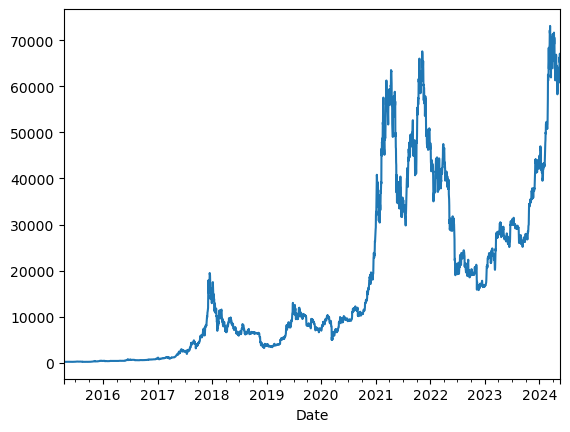

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2015-04-16,228.572998,2.480540e+07
1,2015-04-17,222.882004,2.042980e+07
2,2015-04-18,223.356003,1.293900e+07
3,2015-04-19,222.600006,1.502150e+07
4,2015-04-20,224.626007,1.836470e+07
...,...,...,...
3317,2024-05-15,66267.490000,3.981517e+10
3318,2024-05-16,65231.580000,3.157308e+10
3319,2024-05-17,67051.880000,2.803128e+10
3320,2024-05-18,66940.800000,1.671228e+10


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:57:02 - cmdstanpy - INFO - Chain [1] start processing
17:57:02 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
3407,2024-08-13
3408,2024-08-14
3409,2024-08-15
3410,2024-08-16
3411,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3382,2024-07-19,54746.063091,46391.288847,60198.032937,54055.554246,55188.959333,-1406.715502,-1406.715502,-1406.715502,-14.440576,-14.440576,-14.440576,-1392.274926,-1392.274926,-1392.274926,0.0,0.0,0.0,53339.347589
3383,2024-07-20,54800.333582,46540.425919,59905.535561,54084.714100,55261.029637,-1359.173645,-1359.173645,-1359.173645,-12.281215,-12.281215,-12.281215,-1346.892430,-1346.892430,-1346.892430,0.0,0.0,0.0,53441.159937
3384,2024-07-21,54854.604073,46298.115372,60430.569736,54120.455780,55325.590832,-1295.290845,-1295.290845,-1295.290845,3.561794,3.561794,3.561794,-1298.852638,-1298.852638,-1298.852638,0.0,0.0,0.0,53559.313228
3385,2024-07-22,54908.874564,46475.957017,60302.662647,54161.838483,55397.801383,-1223.868387,-1223.868387,-1223.868387,24.636643,24.636643,24.636643,-1248.505030,-1248.505030,-1248.505030,0.0,0.0,0.0,53685.006177
3386,2024-07-23,54963.145055,46902.494043,60744.917910,54203.221187,55481.914388,-1218.119381,-1218.119381,-1218.119381,-21.893458,-21.893458,-21.893458,-1196.225923,-1196.225923,-1196.225923,0.0,0.0,0.0,53745.025674
3387,2024-07-24,55017.415546,46969.512095,60187.381098,54243.642698,55556.113257,-1101.022275,-1101.022275,-1101.022275,41.394437,41.394437,41.394437,-1142.416712,-1142.416712,-1142.416712,0.0,0.0,0.0,53916.393270
3388,2024-07-25,55071.686036,46898.071973,60194.857679,54270.602514,55645.243073,-1108.479610,-1108.479610,-1108.479610,-20.977625,-20.977625,-20.977625,-1087.501985,-1087.501985,-1087.501985,0.0,0.0,0.0,53963.206426
3389,2024-07-26,55125.956527,47085.733177,60700.714934,54312.054275,55736.453560,-1046.368009,-1046.368009,-1046.368009,-14.440576,-14.440576,-14.440576,-1031.927433,-1031.927433,-1031.927433,0.0,0.0,0.0,54079.588518
3390,2024-07-27,55180.227018,47842.991544,60816.861302,54337.170402,55782.710985,-988.438692,-988.438692,-988.438692,-12.281215,-12.281215,-12.281215,-976.157477,-976.157477,-976.157477,0.0,0.0,0.0,54191.788326
3391,2024-07-28,55234.497509,47814.140034,60826.277632,54362.286529,55848.616133,-917.110732,-917.110732,-917.110732,3.561794,3.561794,3.561794,-920.672525,-920.672525,-920.672525,0.0,0.0,0.0,54317.386777


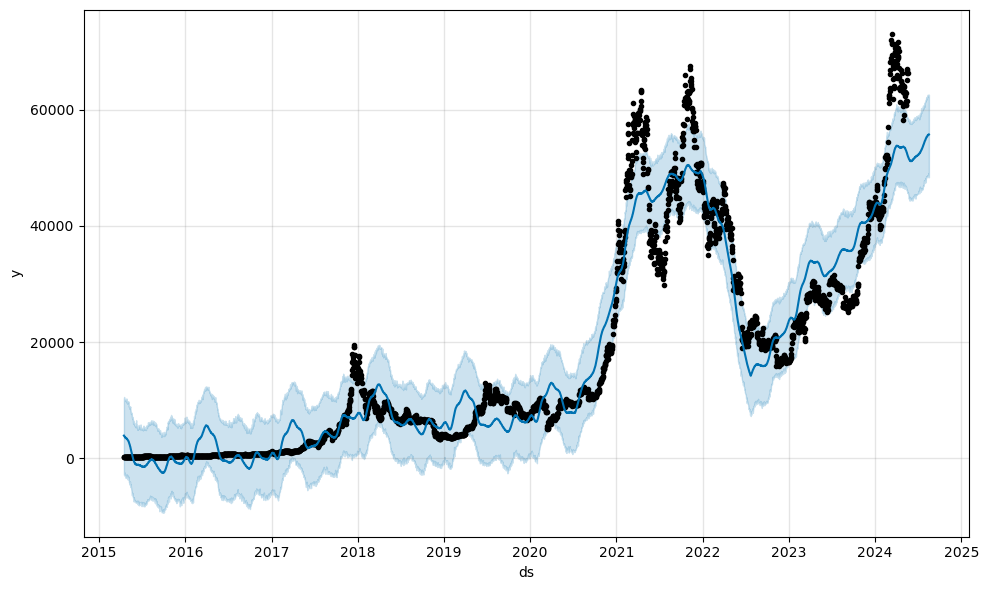

In [20]:
# Plot the Prophet predictions for the data
fig1 = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,52040.539288,45786.188396,58676.253902
2024-05-21,51876.017148,45596.890090,58124.136995
2024-05-22,51827.051425,45291.117624,58340.011414
2024-05-23,51659.385693,44811.736233,58136.035751
2024-05-24,51568.672709,44670.216747,58392.756472
...,...,...,...
2024-08-13,55622.584355,48713.337281,62256.907724
2024-08-14,55723.963482,48732.070772,62403.031116
2024-08-15,55693.507662,49095.447699,62630.449132


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

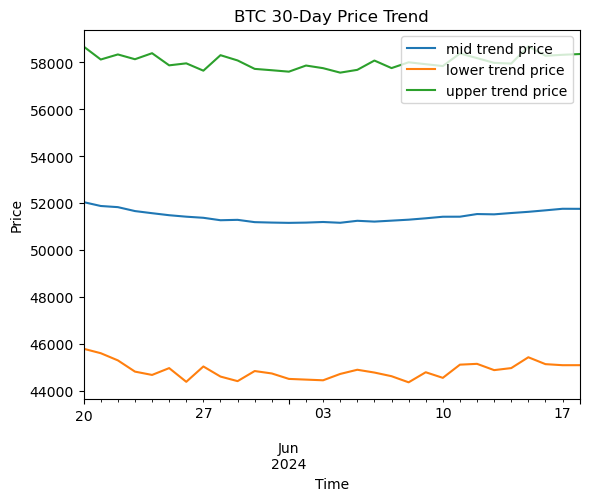

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

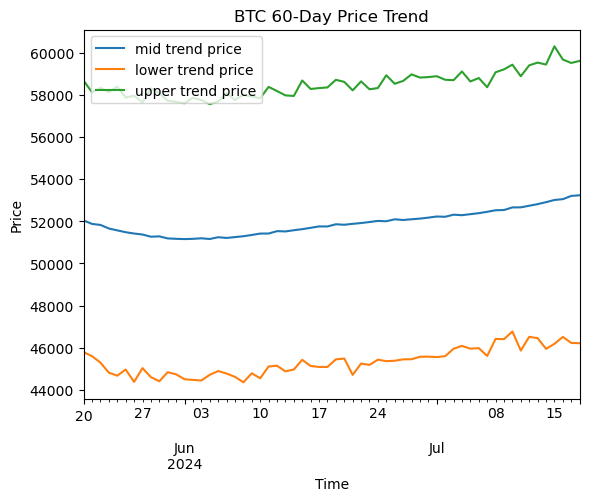

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

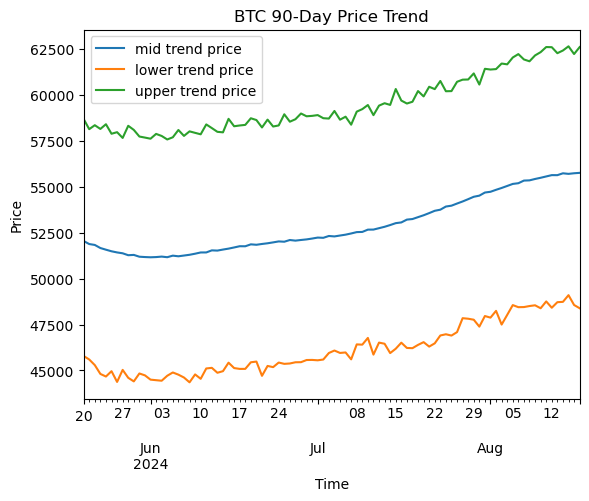

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

66278.37

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

52040.53928781458

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

59159.45464390729

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

52116.81203229837

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

51948.2795821358

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

53321.472910475764

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

55643.574364878405

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.122

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.099

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.059

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

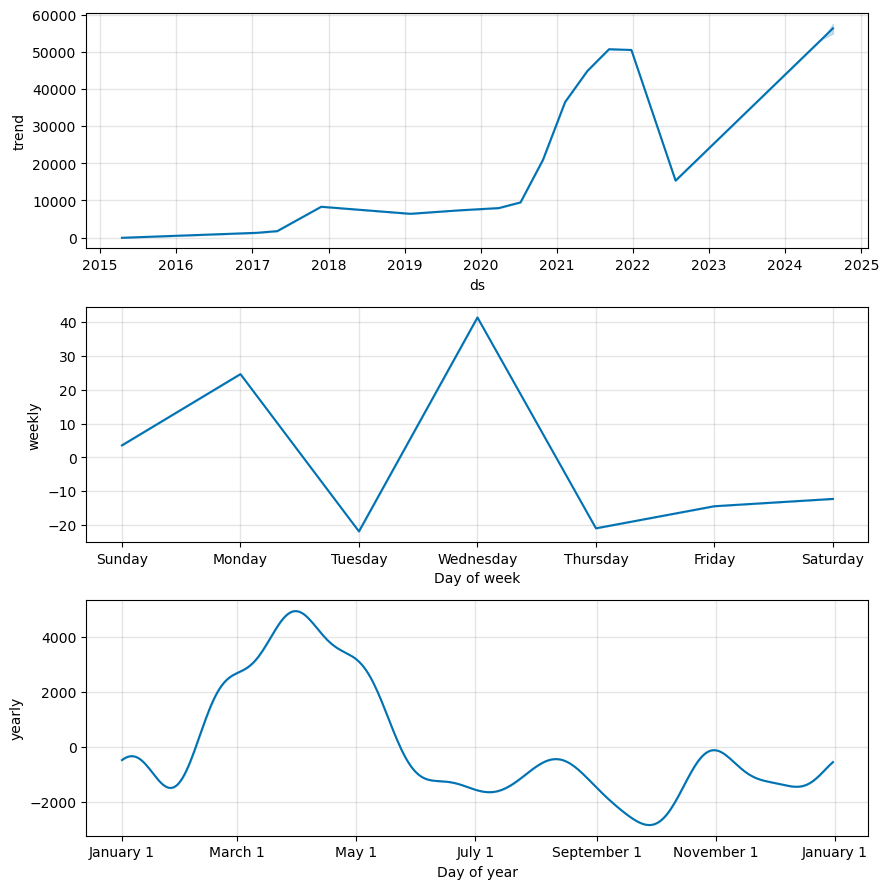

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig2 = crypto_model.plot_components(crypto_forecast)

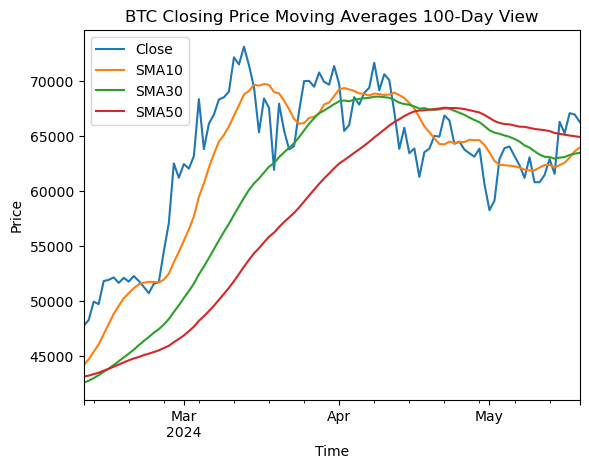

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

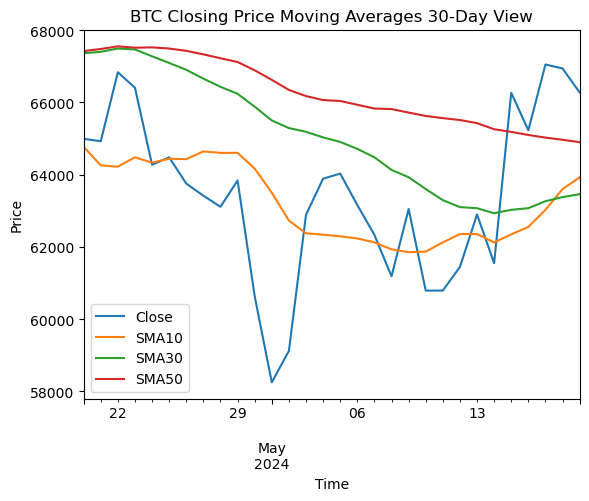

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-20
File created :  2024-05-20.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.467602,0.016141654551261597,-0.048511607018260405,0.26698037580557354
BNB,574.63,-0.3370363083405419,-0.3290568236386213,-0.2790790471601129
BONK,2.5e-05,0.25779530706847753,0.4080859075709553,0.5429258111537147
BTC,66278.37,-0.2191180233361938,-0.1951255528263407,-0.16020045358030566
DOGE,0.149107,-0.22857973922643027,-0.28954294972299366,-0.13383869168157447
ETH,3094.12,-0.05566025624110993,-0.04356552970504457,0.046438254274701274
PEPE,9e-06,0.3163098292378519,0.5695209080409678,0.79019064181281
SHIB,2.4e-05,-0.13447450951251372,-0.07783705937680974,-0.018044767636294923
SOL,170.09,0.02993653747852032,0.09897686371903935,0.15883864333841902
XRP,0.509661,0.08170842018061886,0.1175389631277377,0.251808862234169
ADA,0.467602,-0.05356931769426376,-0.12050457682285454,0.1829944797779357
ADA,0.467602,-0.07589607234414741,-0.135242805763105,0.15993249027663747
BNB,574.63,-0.23839504335644301,-0.2336482812093087,-0.1748296149590688
BONK,2.5e-05,0.1887956631518306,0.32592832450639286,0